### Problem Statement:

Food delivery time analysis <br>
(Idea: https://www.linkedin.com/posts/fabian-werkmeister_food-delivery-data-project-activity-7126214444031844352-MC78?utm_source=share&utm_medium=member_desktop)

In [1]:
import warnings
warnings.filterwarnings("ignore")
import opendatasets as od

In [2]:
od.download("https://www.kaggle.com/datasets/rajatkumar30/food-delivery-time")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: adithyaravi
Your Kaggle Key: ········


100%|███████████████████████████████████████████████████████████████████████████████| 978k/978k [00:00<00:00, 3.76MB/s]

### Understanding the data

In [3]:
import pandas as pd
import numpy as np

df = pd.read_csv("food-delivery-time/deliverytime.csv")

In [4]:
df.shape

(45593, 11)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45593 entries, 0 to 45592
Data columns (total 11 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   ID                           45593 non-null  object 
 1   Delivery_person_ID           45593 non-null  object 
 2   Delivery_person_Age          45593 non-null  int64  
 3   Delivery_person_Ratings      45593 non-null  float64
 4   Restaurant_latitude          45593 non-null  float64
 5   Restaurant_longitude         45593 non-null  float64
 6   Delivery_location_latitude   45593 non-null  float64
 7   Delivery_location_longitude  45593 non-null  float64
 8   Type_of_order                45593 non-null  object 
 9   Type_of_vehicle              45593 non-null  object 
 10  Time_taken(min)              45593 non-null  int64  
dtypes: float64(5), int64(2), object(4)
memory usage: 3.8+ MB


In [6]:
df.describe()

,Delivery_person_Age,Delivery_person_Ratings,Restaurant_latitude,Restaurant_longitude,Delivery_location_latitude,Delivery_location_longitude,Time_taken(min)
count,45593.000000,45593.000000,45593.000000,45593.000000,45593.000000,45593.000000,45593.000000
mean,29.544075,4.632367,17.017729,70.231332,17.465186,70.845702,26.294607
std,5.696793,0.327708,8.185109,22.883647,7.335122,21.118812,9.383806
min,15.000000,1.000000,-30.905562,-88.366217,0.010000,0.010000,10.000000
25%,25.000000,4.600000,12.933284,73.170000,12.988453,73.280000,19.000000
50%,29.000000,4.700000,18.546947,75.898497,18.633934,76.002574,26.000000
75%,34.000000,4.800000,22.728163,78.044095,22.785049,78.107044,32.000000
max,50.000000,6.000000,30.914057,88.433452,31.054057,88.563452,54.000000


#### Task 1:
Create a database and a table using the first 1000 rows from the CSV file and then ingest the remaining rows in chunks of 1000 rows. Also change the data type of the longitude, latitude in the table

In [7]:
import sqlite3

data = pd.read_csv("food-delivery-time/deliverytime.csv", nrows = 1000)
conn = sqlite3.connect("delivery.db")

data.to_sql("delivery", conn, if_exists="replace", index=False)

chunks = 1000
offset_value = 1000

while True:
    chunk_next = pd.read_csv("food-delivery-time/deliverytime.csv", skiprows=range(1,offset_value), nrows=chunks)
    if chunk_next.empty:
        break
        
    chunk_next.to_sql("delivery", conn, if_exists="append", index=False)
    offset_value += chunks

In [8]:
c = conn.cursor()

create_table = '''
    CREATE TABLE IF NOT EXISTS delivery(
       ID INTEGER,
       Delivery_person_ID VARCHAR,
       Delivery_person_Age INTEGER,
       Delivery_person_Ratings REAL,  
       Restaurant_latitude REAL,      
       Restaurant_longitude REAL,     
       Delivery_location_latitude REAL,
       Delivery_location_longitude REAL,
       Type_of_order VARCHAR,
       Type_of_vehicle VARCHAR,
       Time_taken_min INTEGER  
    )
'''

c.execute(create_table)

conn.commit()

In [9]:
c.execute("SELECT COUNT(*) FROM delivery")
num_rows = c.fetchone()[0]

c.execute("PRAGMA table_info(delivery)")
num_columns = len(c.fetchall())

print("Total number of rows:", num_rows)
print("Total number of columns:", num_columns)

c.close()
conn.close()

Total number of rows: 45594
Total number of columns: 11


### Data analysis on the dataset

In [10]:
df.head()

,ID,Delivery_person_ID,Delivery_person_Age,Delivery_person_Ratings,Restaurant_latitude,Restaurant_longitude,Delivery_location_latitude,Delivery_location_longitude,Type_of_order,Type_of_vehicle,Time_taken(min)
0,4607,INDORES13DEL02,37,4.9,22.745049,75.892471,22.765049,75.912471,Snack,motorcycle,24
1,B379,BANGRES18DEL02,34,4.5,12.913041,77.683237,13.043041,77.813237,Snack,scooter,33
2,5D6D,BANGRES19DEL01,23,4.4,12.914264,77.678400,12.924264,77.688400,Drinks,motorcycle,26
3,7A6A,COIMBRES13DEL02,38,4.7,11.003669,76.976494,11.053669,77.026494,Buffet,motorcycle,21
4,70A2,CHENRES12DEL01,32,4.6,12.972793,80.249982,13.012793,80.289982,Snack,scooter,30


#### Task 2:
Analyze delivery data to understand the correlation between delivery times and ratings, vehicle types, and the age of delivery personnel.

In [11]:
vehicle_type = df.groupby('Type_of_vehicle')['Time_taken(min)'].mean()

age_bins = [15, 25, 35, 45, 55]
age_labels = ['15-24', '25-34', '35-44', '45-54']

df['Age_Group'] = pd.cut(df['Delivery_person_Age'], bins=age_bins, labels=age_labels)
person_age = df.groupby('Age_Group')['Time_taken(min)'].mean()

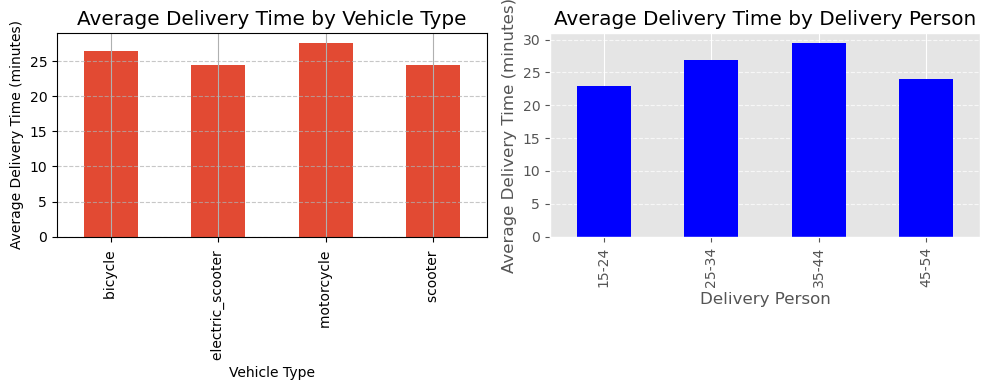

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.style.use("ggplot")
vehicle_type.plot(kind='bar', title='Average Delivery Time by Vehicle Type')
plt.xlabel('Vehicle Type')
plt.ylabel('Average Delivery Time (minutes)')
plt.grid(True, axis='y', linestyle='--', alpha=0.7)


plt.subplot(1,2,2)
plt.style.use("ggplot")
person_age.plot(kind='bar', title='Average Delivery Time by Delivery Person', color ="blue")
plt.xlabel('Delivery Person')
plt.ylabel('Average Delivery Time (minutes)')
plt.grid(True, axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

In [13]:
vehicle_type_ratings = df.groupby('Type_of_vehicle')['Delivery_person_Ratings'].mean()
person_age_ratings = df.groupby('Age_Group')['Delivery_person_Ratings'].mean()

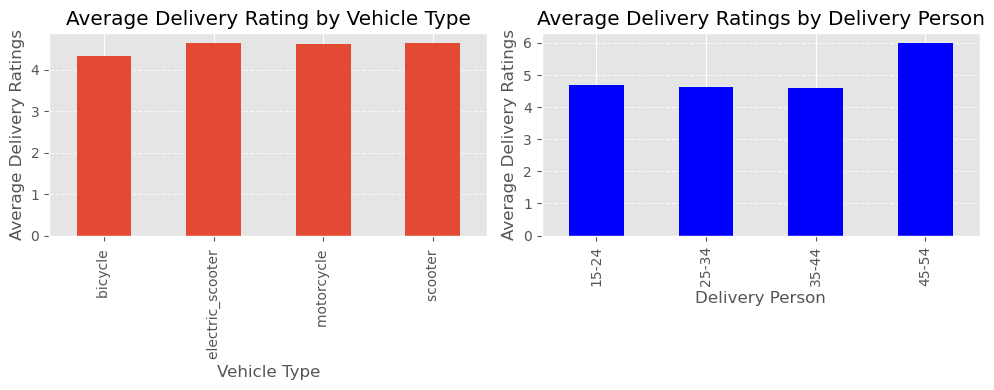

In [14]:
plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.style.use("ggplot")
vehicle_type_ratings.plot(kind='bar', title='Average Delivery Rating by Vehicle Type')
plt.xlabel('Vehicle Type')
plt.ylabel('Average Delivery Ratings')
plt.grid(True, axis='y', linestyle='--', alpha=0.7)


plt.subplot(1,2,2)
plt.style.use("ggplot")
person_age_ratings.plot(kind='bar', title='Average Delivery Ratings by Delivery Person', color ="blue")
plt.xlabel('Delivery Person')
plt.ylabel('Average Delivery Ratings')
plt.grid(True, axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

#### Task 3:
Calculate the delivery distance based on latitude longitutde values and analyze the distribution by vehicle types

In [15]:
# pip install geopy

In [16]:
from geopy.distance import great_circle

def calculate_distance(row):
    delivery_coords = (row['Delivery_location_latitude'], row['Delivery_location_longitude'])
    restaurant_coords = (row['Restaurant_latitude'], row['Restaurant_longitude'])
    return great_circle(delivery_coords, restaurant_coords).miles

In [17]:
df['Delivery_Distance'] = df.apply(calculate_distance, axis=1)
df.head()

,ID,Delivery_person_ID,Delivery_person_Age,Delivery_person_Ratings,Restaurant_latitude,Restaurant_longitude,Delivery_location_latitude,Delivery_location_longitude,Type_of_order,Type_of_vehicle,Time_taken(min),Age_Group,Delivery_Distance
0,4607,INDORES13DEL02,37,4.9,22.745049,75.892471,22.765049,75.912471,Snack,motorcycle,24,35-44,1.879743
1,B379,BANGRES18DEL02,34,4.5,12.913041,77.683237,13.043041,77.813237,Snack,scooter,33,25-34,12.541482
2,5D6D,BANGRES19DEL01,23,4.4,12.914264,77.678400,12.924264,77.688400,Drinks,motorcycle,26,15-24,0.964840
3,7A6A,COIMBRES13DEL02,38,4.7,11.003669,76.976494,11.053669,77.026494,Buffet,motorcycle,21,35-44,4.840738
4,70A2,CHENRES12DEL01,32,4.6,12.972793,80.249982,13.012793,80.289982,Snack,scooter,30,25-34,3.858806


In [18]:
Q1 = df['Delivery_Distance'].quantile(0.25)
Q3 = df['Delivery_Distance'].quantile(0.75)

IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = df[(df['Delivery_Distance'] < lower_bound) | (df['Delivery_Distance'] > upper_bound)]
df_cleaned = df[~((df['Delivery_Distance'] < lower_bound) | (df['Delivery_Distance'] > upper_bound))]

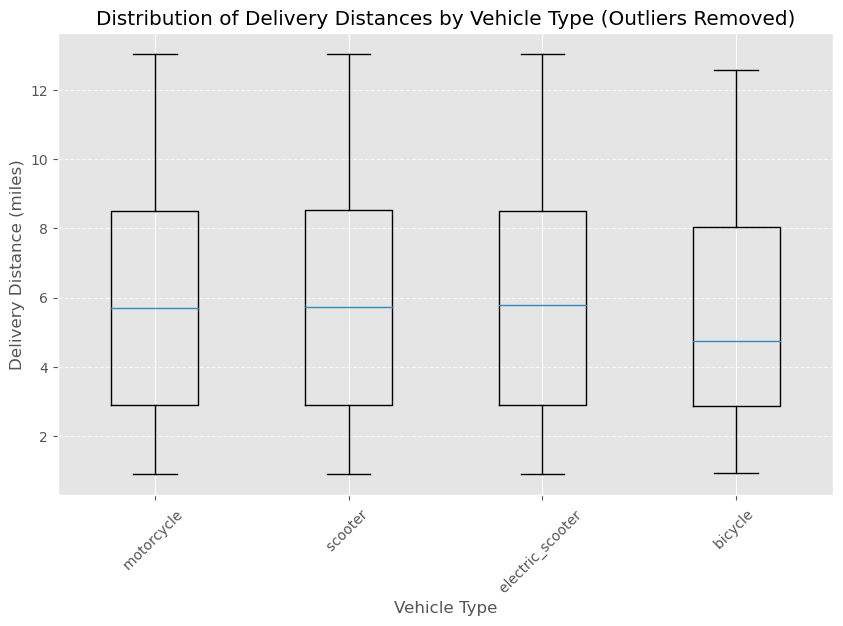

In [19]:
plt.figure(figsize=(10, 6))
plt.title('Distribution of Delivery Distances by Vehicle Type (Outliers Removed)')
plt.xlabel('Vehicle Type')
plt.ylabel('Delivery Distance (miles)')
plt.grid(True, axis='y', linestyle='--', alpha=0.7)

plt.boxplot([df_cleaned[df_cleaned['Type_of_vehicle'] == v]['Delivery_Distance'] for v in df_cleaned['Type_of_vehicle'].unique()],
            labels=df_cleaned['Type_of_vehicle'].unique())
plt.xticks(rotation=45)

plt.show()

The box plot suggests that the distribution of delivery distances varies among these smaller vehicle types. Motorcycles have the widest IQR, indicating a larger spread of delivery distances and the IQR's of scooters and electric scooters are just as same. Bicycles, with the smallest IQR, appear to be utilized for the most localized deliveries among the four vehicle types. However, it's important to note that the presence of outliers, represented by the extreme values extending beyond the whiskers of the box, indicates that even within these smaller vehicle categories, there may be instances of longer-distance deliveries.

Loading cleaned data into a database so that the data remains intact and accessible over time. This also allow for efficient querying and retrieval of specific subsets of data, which can be beneficial for future analysis or reporting. 

In [20]:
conn = sqlite3.connect("delivery.db")
df_cleaned.to_sql("food_table_2", conn, if_exists="replace", index=False)

45162

In [21]:
c = conn.cursor()

c.execute("SELECT COUNT(*) FROM food_table_2")
num_rows = c.fetchone()[0]

c.execute("PRAGMA table_info(food_table_2)")
num_columns = len(c.fetchall())

print("Total number of rows:", num_rows)
print("Total number of columns:", num_columns)

Total number of rows: 45162
Total number of columns: 13


In [22]:
c.execute("SELECT * FROM food_table_2 LIMIT 10")
rows = c.fetchall()
for row in rows:
    print(row)

('4607', 'INDORES13DEL02', 37, 4.9, 22.745049, 75.892471, 22.765049, 75.912471, 'Snack ', 'motorcycle ', 24, '35-44', 1.8797432737549673)
('B379', 'BANGRES18DEL02', 34, 4.5, 12.913041, 77.683237, 13.043041, 77.813237, 'Snack ', 'scooter ', 33, '25-34', 12.541481647813404)
('5D6D', 'BANGRES19DEL01', 23, 4.4, 12.914264, 77.6784, 12.924264, 77.6884, 'Drinks ', 'motorcycle ', 26, '15-24', 0.9648403298237148)
('7A6A', 'COIMBRES13DEL02', 38, 4.7, 11.003669, 76.976494, 11.053669, 77.026494, 'Buffet ', 'motorcycle ', 21, '35-44', 4.8407378194001005)
('70A2', 'CHENRES12DEL01', 32, 4.6, 12.972793, 80.249982, 13.012793, 80.289982, 'Snack ', 'scooter ', 30, '25-34', 3.858806282797298)
('9BB4', 'HYDRES09DEL03', 22, 4.8, 17.431668, 78.408321, 17.461668, 78.438321, 'Buffet ', 'motorcycle ', 26, '15-24', 2.8647521332880452)
('95B4', 'RANCHIRES15DEL01', 33, 4.7, 23.369746, 85.33982, 23.479746, 85.44982, 'Meal ', 'scooter ', 40, '25-34', 10.315000757097824)
('9EB2', 'MYSRES15DEL02', 35, 4.6, 12.352058, 

In [23]:
query = "SELECT * FROM food_table_2"
data = pd.read_sql_query(query, conn)
data.head()

,ID,Delivery_person_ID,Delivery_person_Age,Delivery_person_Ratings,Restaurant_latitude,Restaurant_longitude,Delivery_location_latitude,Delivery_location_longitude,Type_of_order,Type_of_vehicle,Time_taken(min),Age_Group,Delivery_Distance
0,4607,INDORES13DEL02,37,4.9,22.745049,75.892471,22.765049,75.912471,Snack,motorcycle,24,35-44,1.879743
1,B379,BANGRES18DEL02,34,4.5,12.913041,77.683237,13.043041,77.813237,Snack,scooter,33,25-34,12.541482
2,5D6D,BANGRES19DEL01,23,4.4,12.914264,77.678400,12.924264,77.688400,Drinks,motorcycle,26,15-24,0.964840
3,7A6A,COIMBRES13DEL02,38,4.7,11.003669,76.976494,11.053669,77.026494,Buffet,motorcycle,21,35-44,4.840738
4,70A2,CHENRES12DEL01,32,4.6,12.972793,80.249982,13.012793,80.289982,Snack,scooter,30,25-34,3.858806


In [24]:
data.columns

Index(['ID', 'Delivery_person_ID', 'Delivery_person_Age',
       'Delivery_person_Ratings', 'Restaurant_latitude',
       'Restaurant_longitude', 'Delivery_location_latitude',
       'Delivery_location_longitude', 'Type_of_order', 'Type_of_vehicle',
       'Time_taken(min)', 'Age_Group', 'Delivery_Distance'],
      dtype='object')

In [25]:
columns_drop = ['ID','Delivery_person_ID','Type_of_order', 'Type_of_vehicle', 'Age_Group']
data = data.drop(columns = columns_drop, axis = 1)
data.head()

,Delivery_person_Age,Delivery_person_Ratings,Restaurant_latitude,Restaurant_longitude,Delivery_location_latitude,Delivery_location_longitude,Time_taken(min),Delivery_Distance
0,37,4.9,22.745049,75.892471,22.765049,75.912471,24,1.879743
1,34,4.5,12.913041,77.683237,13.043041,77.813237,33,12.541482
2,23,4.4,12.914264,77.678400,12.924264,77.688400,26,0.964840
3,38,4.7,11.003669,76.976494,11.053669,77.026494,21,4.840738
4,32,4.6,12.972793,80.249982,13.012793,80.289982,30,3.858806


#### Task 4:
Develop a model with the necessary features from the dataset to predict the delivery time


I chose to use a RandomForestRegressor model for delivery time prediction task because it's a powerful ensemble method that combines multiple decision trees, making it capable of capturing complex relationships in my dataset. This model doesn't require feature scaling, handles outliers well, and provides valuable feature importance scores to guide my analysis. 

In [26]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_leaf': [1, 2, 4]
}

X = data.drop('Time_taken(min)', axis = 1)
y = data['Time_taken(min)']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=40)

model = RandomForestRegressor(random_state=43)

grid_search = GridSearchCV(model, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_

best_model = RandomForestRegressor(random_state=42, **best_params)
best_model.fit(X_train, y_train)

y_pred = best_model.predict(X_test)
rmse = mean_squared_error(y_test, y_pred, squared=False)
print(f'Root Mean Squared Error (RMSE) with best hyperparameters: {rmse}')

Root Mean Squared Error (RMSE) with best hyperparameters: 7.388560019771165


A Root Mean Squared Error of approximately 7.39 indicates that the machine learning model has an average prediction error of 7.39 units of the target variable, which is 7.4 minutes approximately